In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3 as sq
from datetime import datetime, timedelta, date
from netaddr import IPNetwork
import re
from pprint import pprint
from IPython.display import Markdown, display, HTML
import matplotlib.ticker as mtick
import scipy.stats as stats

In [2]:
protocols = ['QUIC', 'TLS', 'HTTPS', 'TCP', 'UDP']
plt.rcParams.update({'font.size': 18})

In [3]:
connection = sq.connect("../dataset/merged-web.db")
connection.row_factory = sq.Row

In [4]:
query = """
SELECT id, domain, protocol, server, vantagePoint, requestStart, responseStart, firstContentfulPaint, loadEventStart, loadEventEnd, encodedBodySize, decodedBodySize, transferSize, timestamp, redirectEnd
FROM measurements 
WHERE (error = "" or error is null) AND cacheWarming = 0 AND decodedBodySize > 0 AND vantagePoint != 'US East'
"""
df1 = pd.read_sql(query, connection, index_col="id")
df1.head()

,domain,protocol,server,vantagePoint,requestStart,responseStart,firstContentfulPaint,loadEventStart,loadEventEnd,encodedBodySize,decodedBodySize,transferSize,timestamp,redirectEnd
id,,,,,,,,,,,,,,
de94a059-5d68-a5ce-59ce-1a6ef56c734b,www.google.com,tls,34.101.136.158,Asia Pacific Northeast,449.4,572.8,667.1,1515.4,1520.9,43518,131394,43818,2022-04-18 00:01:07.454673,0.0
17d50fd0-b5a0-79b1-f3a0-7783bd2560c4,www.youtube.com,tls,34.101.136.158,Asia Pacific Northeast,430.2,525.2,1189.7,2451.7,2452.3,72348,798841,72648,2022-04-18 00:01:15.983375,0.0
5a070af4-ccb9-6b98-8858-aa13c35c5e79,www.facebook.com,tls,34.101.136.158,Asia Pacific Northeast,426.1,789.8,1439.4,1825.8,1830.0,23902,79882,24202,2022-04-18 00:01:23.922335,0.0
908e3a2b-a713-d249-2134-48820f931020,www.netflix.com,tls,34.101.136.158,Asia Pacific Northeast,802.8,1106.8,1554.2,2856.7,2856.7,40082,293175,40382,2022-04-18 00:01:31.049555,802.4
7d5d3b00-aa62-96da-299a-ef1525f87ab2,www.microsoft.com,tls,34.101.136.158,Asia Pacific Northeast,571.9,801.5,1519.8,1940.4,1948.6,47126,210946,47426,2022-04-18 00:01:38.612872,571.4


In [5]:
domain_order = df1.head(10)['domain'].tolist()

In [6]:
query = """
SELECT measurement_id, MAX(elapsed), MIN(elapsed), AVG(elapsed), COUNT(answer)
FROM lookups 
WHERE status = "NOERROR"
GROUP BY measurement_id
"""
df2 = pd.read_sql(query, connection, index_col="measurement_id")
df2.index.names = ['id']
df2.rename({'MAX(elapsed)': 'max_lookup_end', 'MIN(elapsed)': 'min_lookup_end', 'AVG(elapsed)': 'avg_lookup_end', 'COUNT(answer)': 'queries'}, axis=1, inplace=True)
df2.head()

,max_lookup_end,min_lookup_end,avg_lookup_end,queries
id,,,,
00002031-da3b-2369-6e3c-292d69af398a,467.196775,154.967710,187.101895,10
00002d25-2747-230e-3914-998bd6b96b55,560.219597,186.824821,311.719236,3
00003cc3-21c6-2931-f9be-7a726658a611,450.794165,152.656857,295.270936,8
000048ab-fefb-2b4d-1222-9d7567b583ea,310.404117,273.878427,286.136316,3
00006444-75d0-8e98-ee35-2ba26c3e54c0,501.352256,137.401209,250.574097,8


In [7]:
query = """
SELECT measurement_id, answer, elapsed
FROM lookups
WHERE 
(domain = "www.google.com."
OR domain = "www.youtube.com."
OR domain = "www.facebook.com."
OR domain = "www.netflix.com."
OR domain = "www.microsoft.com."
OR domain = "twitter.com."
OR domain = "www.instagram.com."
OR domain = "www.linkedin.com."
OR domain = "www.wikipedia.org."
OR domain = "www.baidu.com.")
GROUP BY measurement_id
"""
df3 = pd.read_sql(query, connection, index_col="measurement_id")
df3.index.names = ['id']
df3.head()

,answer,elapsed
id,,
00002031-da3b-2369-6e3c-292d69af398a,"www.google.com.,48,IN,A,142.250.204.4|",155.697689
00002d25-2747-230e-3914-998bd6b96b55,"www.facebook.com.,26,IN,CNAME,star-mini.c10r.f...",560.219597
00003cc3-21c6-2931-f9be-7a726658a611,"www.microsoft.com.,5,IN,CNAME,www.microsoft.co...",450.794165
000048ab-fefb-2b4d-1222-9d7567b583ea,"www.instagram.com.,1084,IN,CNAME,geo-p42.insta...",310.404117
00006444-75d0-8e98-ee35-2ba26c3e54c0,"twitter.com.,809,IN,A,104.244.42.65|twitter.co...",501.352256


In [8]:
df = pd.merge(df1, df2, 'left', on='id')
df = pd.merge(df, df3, 'left', on='id')
df['protocol'] = df['protocol'].str.upper()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head(10)

,domain,protocol,server,vantagePoint,requestStart,responseStart,firstContentfulPaint,loadEventStart,loadEventEnd,encodedBodySize,decodedBodySize,transferSize,timestamp,redirectEnd,max_lookup_end,min_lookup_end,avg_lookup_end,queries,answer,elapsed
id,,,,,,,,,,,,,,,,,,,,
de94a059-5d68-a5ce-59ce-1a6ef56c734b,www.google.com,TLS,34.101.136.158,Asia Pacific Northeast,449.4,572.8,667.1,1515.4,1520.9,43518,131394,43818,2022-04-18 00:01:07.454673,0.0,265.857882,88.543562,127.501060,5,"www.google.com.,245,IN,A,172.217.194.106|www.g...",265.857882
17d50fd0-b5a0-79b1-f3a0-7783bd2560c4,www.youtube.com,TLS,34.101.136.158,Asia Pacific Northeast,430.2,525.2,1189.7,2451.7,2452.3,72348,798841,72648,2022-04-18 00:01:15.983375,0.0,266.068803,87.172790,141.118718,10,"www.google.com.,234,IN,A,172.217.194.106|www.g...",88.947238
5a070af4-ccb9-6b98-8858-aa13c35c5e79,www.facebook.com,TLS,34.101.136.158,Asia Pacific Northeast,426.1,789.8,1439.4,1825.8,1830.0,23902,79882,24202,2022-04-18 00:01:23.922335,0.0,263.154500,87.636232,146.156522,3,"www.facebook.com.,297,IN,A,31.13.68.35|",263.154500
908e3a2b-a713-d249-2134-48820f931020,www.netflix.com,TLS,34.101.136.158,Asia Pacific Northeast,802.8,1106.8,1554.2,2856.7,2856.7,40082,293175,40382,2022-04-18 00:01:31.049555,802.4,266.573831,85.928809,162.243046,7,"www.netflix.com.,296,IN,A,52.38.7.83|www.netfl...",262.431446
7d5d3b00-aa62-96da-299a-ef1525f87ab2,www.microsoft.com,TLS,34.101.136.158,Asia Pacific Northeast,571.9,801.5,1519.8,1940.4,1948.6,47126,210946,47426,2022-04-18 00:01:38.612872,571.4,269.910491,83.194761,160.144367,10,"www.microsoft.com.,297,IN,A,23.195.153.175|",250.034221
5aa29070-1949-e582-3be3-25f86b484f99,www.instagram.com,TLS,34.101.136.158,Asia Pacific Northeast,694.3,1125.1,1148.7,2284.2,2285.3,28742,95433,29042,2022-04-18 00:01:45.687286,693.5,263.681110,87.757407,146.501902,3,"www.instagram.com.,297,IN,A,31.13.68.174|",263.681110
2f7c5ad0-02a5-3cbb-b35c-730234d23c60,twitter.com,TLS,34.101.136.158,Asia Pacific Northeast,307.5,441.2,562.0,873.7,873.7,20659,98716,20959,2022-04-18 00:01:51.669557,0.0,265.456855,88.345981,176.180690,4,"twitter.com.,795,IN,A,104.244.42.193|twitter.c...",265.456855
c8cad7cc-50e9-60e2-d146-a8d5a109e74c,www.baidu.com,TLS,34.101.136.158,Asia Pacific Northeast,425.2,539.2,898.1,2041.7,2046.6,87853,354074,88153,2022-04-18 00:01:57.582608,0.0,264.591755,87.712718,146.533715,6,"www.baidu.com.,297,IN,A,45.113.192.101|www.bai...",263.117028
7b47a9f9-5ffd-a6e0-f38a-1fbcd243a481,www.linkedin.com,TLS,34.101.136.158,Asia Pacific Northeast,298.2,628.1,1023.7,1147.4,1147.4,14948,127559,15248,2022-04-18 00:02:03.294836,0.0,282.891974,83.704866,209.882300,4,"www.linkedin.com.,298,IN,A,13.107.42.14|",250.811192


In [9]:
# order vantage Points
vp_order = ['US West', 'South America East', 'Europe Central', 'Asia Pacific Southeast', 'Asia Pacific Northeast', 'Africa South']

In [10]:
# Eliminate unwanted servers
servers_to_exclude = ['138.2.86.147', '43.132.147.94', '120.55.44.44', '199.101.171.125', '202.61.207.68', '168.138.163.222', '203.160.55.187', '37.114.32.80', '103.176.79.211', '47.107.121.125', '47.243.237.126', '93.115.24.205', '62.109.2.197']
df_tmp = df[~df.server.isin(servers_to_exclude)].copy()
df = df_tmp

In [11]:
len(df)

284133

In [12]:
# some metrics
df['timeByTransferSize'] = df['loadEventStart'] / df['transferSize']
df['timeByDecodedSize'] = df['loadEventStart'] / df['decodedBodySize']
df['difLookupFcp'] = df['firstContentfulPaint'] - df['max_lookup_end']
df['difFcpEnd'] = df['loadEventStart'] - df['firstContentfulPaint']
df['difLookupEnd'] = df['loadEventStart'] - df['elapsed']
df['serverRTT'] = df['responseStart'] - df['requestStart']

In [13]:
# order by average number of queries
df_new = df[['domain', 'queries']].copy()
df_new = df_new.groupby('domain').agg('mean')
df_new = df_new.sort_values('queries')
domain_order = df_new.index.tolist()

In [14]:
# Difference between DoUDP and DoQ/DoT/DoH/DoTCP
diff_dict2 = {'domain': [], 'vantagePoint': [], 'server': [], 'QUIC-PLT': [], 'QUIC-FCP': [], 'TLS-PLT': [], 'TLS-FCP': [], 
             'HTTPS-PLT': [], 'HTTPS-FCP': [], 'TCP-PLT': [], 'TCP-FCP': [], 'RTT_over_10ms': []}

for vp in vp_order:
    df_vp = df[df['vantagePoint'] == vp].copy()
    for server in df_vp['server'].unique():
        df_server = df_vp[df_vp['server'] == server].copy()
        for domain in domain_order:
            df_domain = df_server[df_server['domain'] == domain].copy()
            
            start_date = date(2022, 4, 18)
            end_date = date(2022, 4, 24)
            delta = timedelta(days=2)
            df_domain['timestamp'] = pd.to_datetime(df_domain['timestamp']).dt.date
            
            # we remove iterations with faulty measurements
            while start_date <= end_date:
                df_timeframe = df_domain[(df_domain['timestamp'] >= start_date) & (df_domain['timestamp'] < (start_date+delta))].copy()
                
                tmp_list = []
                for protocol in ['UDP', 'QUIC', 'TLS', 'HTTPS', 'TCP']:
                    df_protocol = df_timeframe[df_timeframe['protocol'] == protocol].copy()
                    tmp_list += df_protocol['firstContentfulPaint'].tolist()
                    tmp_list += df_protocol['loadEventEnd'].tolist()
                    
                if 0.0 in tmp_list or np.nan in tmp_list:
                    df_domain = df_domain[(df_domain['timestamp'] < start_date) | (df_domain['timestamp'] >= (start_date+delta))]
                start_date += delta
            
            df_udp = df_domain[df_domain['protocol'] == 'UDP'].copy()
            if not df_udp.empty:
                # udp baseline
                median_plt_udp = df_udp['loadEventStart'].median()
                median_fcp_udp = df_udp['firstContentfulPaint'].median()
                median_rtt = df_udp['avg_lookup_end'].median()
                # add PLT and FCP increase
                for protocol in ['QUIC', 'TLS', 'HTTPS', 'TCP']:
                    df_protocol = df_domain[df_domain['protocol'] == protocol].copy()
                    median_plt_protocol = df_protocol['loadEventStart'].median()
                    median_fcp_protocol = df_protocol['firstContentfulPaint'].median()

                    increase_plt = (median_plt_protocol/(median_plt_udp/100))-100
                    increase_fcp = (median_fcp_protocol/(median_fcp_udp/100))-100

                    diff_dict2[f"{protocol}-PLT"].append(increase_plt)
                    diff_dict2[f"{protocol}-FCP"].append(increase_fcp)

                # add vantage point, server and domain information
                diff_dict2['vantagePoint'].append(vp)
                diff_dict2['domain'].append(domain)
                diff_dict2['server'].append(server)
                # add information if resolver rtt is over 10 ms
                diff_dict2['RTT_over_10ms'].append(median_rtt > 10)
                
diff_df2 = pd.DataFrame.from_dict(diff_dict2)

diff_df2.rename(columns={"QUIC-PLT": "DoQ-PLT", "QUIC-FCP": "DoQ-FCP", "TLS-PLT": "DoT-PLT", "TLS-FCP": "DoT-FCP",
                        "HTTPS-PLT": "DoH-PLT", "HTTPS-FCP": "DoH-FCP", "TCP-PLT": "DoTCP-PLT", "TCP-FCP": "DoTCP-FCP"}, inplace=True)

In [15]:
# Difference between DoQ and DoH/DoT/DoUDP
diff_dict3 = {'domain': [], 'vantagePoint': [], 'server': [], 'HTTPS-PLT': [], 'HTTPS-FCP': [], 'TLS-PLT': [], 'TLS-FCP': [], 'UDP-PLT': [], 'UDP-FCP': [], 'RTT': []}

for vp in vp_order:
    df_vp = df[df['vantagePoint'] == vp].copy()
    for server in df_vp['server'].unique():
        df_server = df_vp[df_vp['server'] == server].copy()
        for domain in domain_order:
            df_domain = df_server[df_server['domain'] == domain].copy()
            
            start_date = date(2022, 4, 18)
            end_date = date(2022, 4, 24)
            delta = timedelta(days=2)
            df_domain['timestamp'] = pd.to_datetime(df_domain['timestamp']).dt.date
            
            # we remove iterations with faulty measurements
            while start_date <= end_date:
                df_timeframe = df_domain[(df_domain['timestamp'] >= start_date) & (df_domain['timestamp'] < (start_date+delta))].copy()
                
                tmp_list = []
                for protocol in ['UDP', 'QUIC', 'TLS', 'HTTPS', 'TCP']:
                    df_protocol = df_timeframe[df_timeframe['protocol'] == protocol].copy()
                    tmp_list += df_protocol['firstContentfulPaint'].tolist()
                    tmp_list += df_protocol['loadEventEnd'].tolist()
                    
                if 0.0 in tmp_list or np.nan in tmp_list:
                    df_domain = df_domain[(df_domain['timestamp'] < start_date) | (df_domain['timestamp'] >= (start_date+delta))]
                start_date += delta
                
            df_doh = df_domain[df_domain['protocol'] == 'QUIC'].copy()
            if not df_doh.empty:
                # doh baseline
                median_plt_doh = df_doh['loadEventStart'].median()
                median_fcp_doh = df_doh['firstContentfulPaint'].median()
                
                # add vantage point, server and domain information
                diff_dict3['vantagePoint'].append(vp)
                diff_dict3['domain'].append(domain)
                diff_dict3['server'].append(server)
                
                # add PLT and FCP increase
                for protocol in ['HTTPS', 'TLS', 'UDP']:
                    df_protocol = df_domain[df_domain['protocol'] == protocol].copy()
                    median_plt_protocol = df_protocol['loadEventStart'].median()
                    median_fcp_protocol = df_protocol['firstContentfulPaint'].median()
                    
                    increase_plt = (median_plt_protocol/(median_plt_doh/100))-100
                    increase_fcp = (median_fcp_protocol/(median_fcp_doh/100))-100
                    
                    diff_dict3[f"{protocol}-PLT"].append(increase_plt)
                    diff_dict3[f"{protocol}-FCP"].append(increase_fcp)
                    
                # add information of resolver rtt
                df_dou = df_domain[df_domain['protocol'] == 'UDP'].copy()
                min_rtt = df_dou['min_lookup_end'].min()
                diff_dict3['RTT'].append(min_rtt)
                
diff_df3 = pd.DataFrame.from_dict(diff_dict3)

diff_df3.rename(columns={"HTTPS-PLT": "DoH-PLT", "HTTPS-FCP": "DoH-FCP", "TLS-PLT": "DoT-PLT", "TLS-FCP": "DoT-FCP",
                        "UDP-PLT": "DoUDP-PLT", "UDP-FCP": "DoUDP-FCP"}, inplace=True)

# Functions

In [27]:
def calculateCDF(items, bins=500):
    count, bins_count = np.histogram(items, bins=bins)
    pdf = count / sum(count)
    # using numpy np.cumsum to calculate the CDF
    cdf = np.cumsum(pdf)
    # return bins_count, cdf
    return bins_count[1:], cdf

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
    
def draw_grid_line(axis, horizontal, mark, xs, ys):
    if horizontal:
        idx = find_nearest(ys, mark)
        axis.hlines([mark], -20, xs[idx], 'k', linestyles='dotted')
        axis.vlines([xs[idx]], 0, mark, 'k', linestyles='dotted')
    else:
        idx = find_nearest(xs, mark)
        axis.vlines([mark], 0, ys[idx], 'k', linestyles='dotted')
        axis.hlines([ys[idx]], -20, mark, 'k', linestyles='dotted')
        
def create_comparison(data, ax, metric='PLT', baseline='DoUDP', compare_to='DoQ', compare_to_2=None, showleg=False):
    # for the cluster plot
    if compare_to_2:
        key = f'{compare_to_2}-{metric}'
        y = data[[key]].copy()
        y = y[y[key] < np.inf]
        y = y[~np.isnan(y)]
        plot_a, plot_n = calculateCDF(y, bins=400)
        sns.lineplot(x=plot_a, y=plot_n, ax=ax, linewidth=3, label='DoUDP', color=sns.color_palette("tab10")[4])
    
    key = f'{compare_to}-{metric}'
    x = data[[key]].copy()
    x = x[x[key] < np.inf]
    x = x[~np.isnan(x)]
    plot_x, plot_y = calculateCDF(x, bins=400)
    zero = find_nearest(plot_x, 0)
    sns.lineplot(x=plot_x, y=plot_y, ax=ax, linewidth=3, label=compare_to, color=sns.color_palette("tab10")[2])
    ax.vlines([0], -0.1, 1, 'k', linestyles='dashed')


    ax.set_facecolor(plt.cm.binary((plot_y[zero]/1.1)))   # or /1.25, values >1.25 lose too much contrast
    ax.tick_params(left=True, bottom=True, labelsize=17)
    ax.yaxis.set_ticks(np.arange(0.0, 1.01, 0.5))
    ax.xaxis.set_ticks(np.arange(-20, 21, 20))
    ax.tick_params(which='minor', bottom=True, labelsize=17, length=6, width=1)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlim(-25, 25)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())
    ax.grid(False)
    ax.spines[['bottom', 'top', 'left', 'right']].set_visible(False)
    
    if showleg:
        leg = ax.legend(loc="best", fontsize='small', framealpha=0.8, handlelength=1)
        for line in leg.get_lines():
            line.set_linewidth(3.0)
    else:
        ax.get_legend().remove()

## Plots

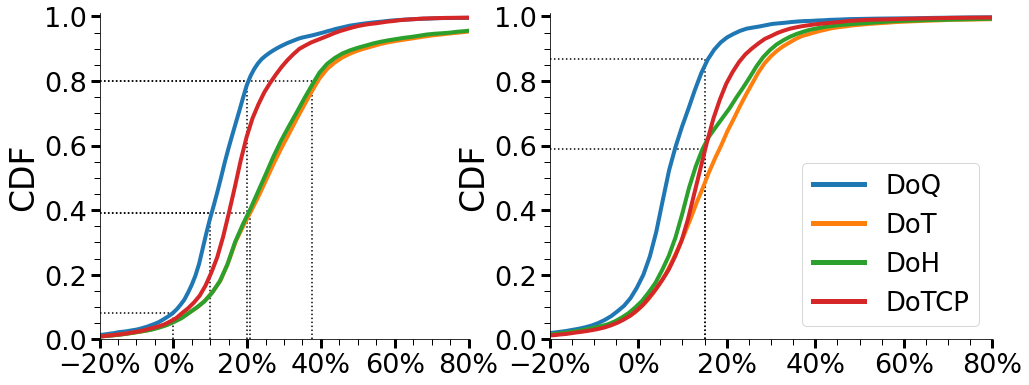

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6), gridspec_kw = {'wspace':0.2, 'hspace':0.1, 'width_ratios': [5, 6]}, sharex=True)

### left plot ###
xs = {}
ys = {}
for protocol in ['DoQ', 'DoT', 'DoH', 'DoTCP']:
    key = f'{protocol}-FCP'
    x = diff_df2[[key]].copy()
    x = x[x[key] < np.inf]
    x = x[~np.isnan(x)]
    xs[protocol], ys[protocol] = calculateCDF(x, bins=400)    
    sns.lineplot(x=xs[protocol], y=ys[protocol], label=protocol, ax=ax1, linewidth=4)

# Labels
ax1.set_ylabel("CDF", fontsize = 33)

# Y axis
ax1.set_ylim(0.0, 1.01)
ax1.yaxis.set_ticks(np.arange(0.0, 1.01, 0.2))
ax1.yaxis.set_minor_locator(mtick.AutoMinorLocator())

# X axis
ax1.set_xlim(-20, 80)
ax1.xaxis.set_ticks(np.arange(-20, 81, 20))
ax1.xaxis.set_minor_locator(mtick.AutoMinorLocator())
ax1.xaxis.set_major_formatter(mtick.PercentFormatter())

ax1.tick_params(which='major', left=True, bottom=True, labelsize=27, width=3, length=9)
ax1.tick_params(which='minor', left=True, bottom=True, width=1, length=6)

# Legend
leg = ax1.legend(loc="lower right", fontsize='x-large')
for line in leg.get_lines():
    line.set_linewidth(5.0)
ax1.get_legend().remove()

# "grid" 
ax1.grid(False)
draw_grid_line(ax1, True, 0.39, xs['DoQ'], ys['DoQ'])
draw_grid_line(ax1, True, 0.39, xs['DoH'], ys['DoH'])
draw_grid_line(ax1, True, 0.8, xs['DoQ'], ys['DoQ'])
draw_grid_line(ax1, True, 0.8, xs['DoH'], ys['DoH'])
draw_grid_line(ax1, False, 0, xs['DoQ'], ys['DoQ'])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

### right plot ###
xs = {}
ys = {}
for protocol in ['DoQ', 'DoT', 'DoH', 'DoTCP']:
    key = f'{protocol}-PLT'
    x = diff_df2[[key]].copy()
    x = x[x[key] < np.inf]
    x = x[~np.isnan(x)]
    xs[protocol], ys[protocol] = calculateCDF(x, bins=400)    
    sns.lineplot(x=xs[protocol], y=ys[protocol], label=protocol, ax=ax2, linewidth=4)

# Labels
ax2.set_ylabel("CDF", fontsize = 33)

# Y axis
ax2.set_ylim(0.0, 1.01)
ax2.yaxis.set_ticks(np.arange(0.0, 1.01, 0.2))
ax2.yaxis.set_minor_locator(mtick.AutoMinorLocator())

# X axis
ax2.set_xlim(-20, 80)
ax2.xaxis.set_ticks(np.arange(-20, 81, 20))
ax2.xaxis.set_minor_locator(mtick.AutoMinorLocator())
ax2.xaxis.set_major_formatter(mtick.PercentFormatter())

ax2.tick_params(which='major', left=True, bottom=True, labelsize=27, width=3, length=9)
ax2.tick_params(which='minor', left=True, bottom=True, width=1, length=6)

# Legend
leg = ax2.legend(loc="lower right", fontsize='x-large')
for line in leg.get_lines():
    line.set_linewidth(5.0)

# "grid" 
ax2.grid(False)
draw_grid_line(ax2, False, 15, xs['DoH'], ys['DoH'])
draw_grid_line(ax2, False, 15, xs['DoQ'], ys['DoQ'])

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)


fig.show()
fig.savefig('plots/udp-baseline-fcp-plt.pdf', bbox_inches='tight')


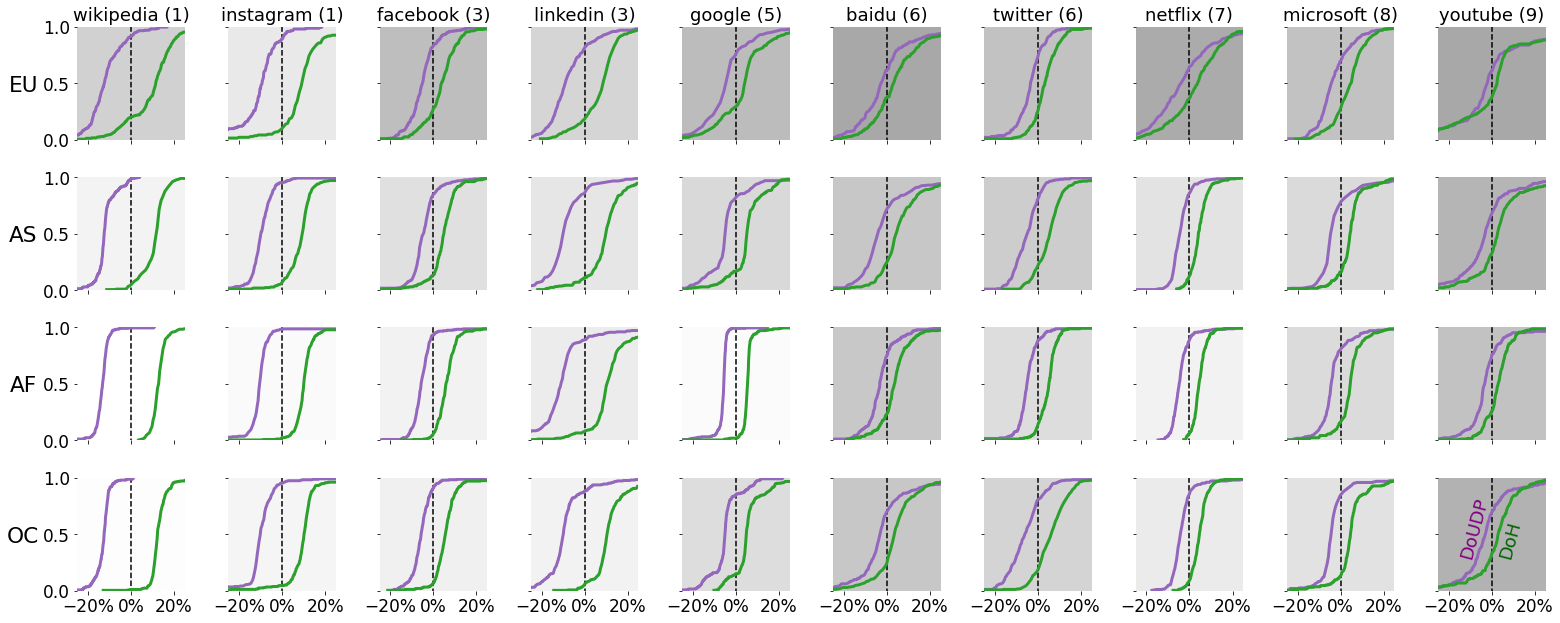

In [29]:
fig, axs = plt.subplots(4, 10, figsize=(22, 9), sharex=True, sharey=True)
tmp_order = ['Europe Central', 'Asia Pacific Northeast', 'Africa South', 'Asia Pacific Southeast']

for i, domain in enumerate(domain_order):
    for j, vp in enumerate(tmp_order):
        ax = axs[j, i]
        data = diff_df3[(diff_df3['vantagePoint'] == vp) & (diff_df3['domain'] == domain)].copy()
        showleg=False
        if (i == 9 and j == 3):  # bottom right plot
            ax.annotate('DoUDP', (-16, 0.3), ha='left', rotation=75, color='purple')
            ax.annotate('DoH', (2.5, 0.3), ha='left', rotation=75, color='darkgreen')
        create_comparison(data, ax, metric='PLT', baseline='DoQ', compare_to='DoH', compare_to_2='DoUDP', showleg=showleg)
            
tmp_order = []        
for index, row in df_new.iterrows():
    tmp_order.append(f"{index.split('.')[-2]} ({int(row['queries'])})")

for ax, col in zip(axs[0], tmp_order):
    ax.set_title(col, size='medium')

for ax, row in zip(axs[:,0], ['EU', 'AS', 'AF', 'OC']):
    ax.set_ylabel(row, rotation=0, size='large', labelpad=0)
    ax.yaxis.set_label_coords(-0.5,0.395)

fig.tight_layout()
plt.savefig("plots/doq-baseline-cluster-annot.pdf", bbox_inches='tight')
plt.show()